In [73]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm
from torchinfo import summary

In [2]:
# Preprocessing
transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5),inplace=True)
    ]
)

In [3]:
Train_Data_Path= r'C:\Users\pawan\Downloads\Intel\intel\seg_train\seg_train'
Test_Data_Path= r'C:\Users\pawan\Downloads\Intel\intel\seg_test\seg_test'

In [4]:
# Prepareing Dataloaders
train_dataset = ImageFolder(Train_Data_Path, transform=transform)
test_dataset = ImageFolder(Test_Data_Path, transform=transform)

train_loader= DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader= DataLoader(test_dataset, batch_size=32, shuffle=False)

In [91]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [99]:
model = resnet50(weights =ResNet50_Weights.IMAGENET1K_V1)
model = model.to(device)

In [100]:
model.fc = nn.Linear(in_features=2048, out_features=6, bias=True)
model.fc

Linear(in_features=2048, out_features=6, bias=True)

In [103]:
summary(model, input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 6]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

In [109]:
optimizer = optim.SGD(model.parameters(), lr=1e-2 , momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [102]:
# Training and testing the Model
def train_model(model, num_epochs, train_loader, test_loader, criterion, optimizer):

    for epoch in range(1, num_epochs+1):
        print(f'\nEpoch: {epoch}/{num_epochs}')
        train_loss, test_loss = [], []
        train_acc, test_acc = [], []


        # Training
        model.train()
        for image, label in tqdm(train_loader , desc= 'Training'):
            image, label = image.to(device), label.to(device)

            # Forward propagation
            optimizer.zero_grad()
            output = model.forward(image)

            # Calculate loss
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            # Record metrics
            train_loss.append(loss.item())
            predictions = torch.argmax(output, axis=1)
            accuracy = (predictions == label).float().mean().item()
            train_acc.append(accuracy)


        # Testing
        model.eval()
        for image, label in tqdm(test_loader, desc='Testing'):
            with torch.no_grad():
                image, label = image.to(device), label.to(device)

                output = model.forward(image)
                loss = criterion(output, label)
                test_loss.append(loss.item())

                predictions = torch.argmax(output, axis=1)
                accuracy = (predictions == label).float().mean().item()
                test_acc.append(accuracy)

        # Print metrices
        print(f'\nTraining Loss: {np.mean(train_loss):.4f} ')
        print(f'\nTesting Loss: {np.mean(test_loss):.4f} ')
        print(f'\nTraining Accuracy: {np.mean(train_acc):.4f} ')
        print(f'\nTesting Accuracy: {np.mean(test_acc):.4f} ')

    return model


In [96]:
for name, parameters in model.named_parameters():
    print(name, parameters.requires_grad)
#     if name not in ["fc.weight", "fc.bias"]:
#         print (name, parameters.requires_grad)


conv1.weight True
bn1.weight True
bn1.bias True
layer1.0.conv1.weight True
layer1.0.bn1.weight True
layer1.0.bn1.bias True
layer1.0.conv2.weight True
layer1.0.bn2.weight True
layer1.0.bn2.bias True
layer1.0.conv3.weight True
layer1.0.bn3.weight True
layer1.0.bn3.bias True
layer1.0.downsample.0.weight True
layer1.0.downsample.1.weight True
layer1.0.downsample.1.bias True
layer1.1.conv1.weight True
layer1.1.bn1.weight True
layer1.1.bn1.bias True
layer1.1.conv2.weight True
layer1.1.bn2.weight True
layer1.1.bn2.bias True
layer1.1.conv3.weight True
layer1.1.bn3.weight True
layer1.1.bn3.bias True
layer1.2.conv1.weight True
layer1.2.bn1.weight True
layer1.2.bn1.bias True
layer1.2.conv2.weight True
layer1.2.bn2.weight True
layer1.2.bn2.bias True
layer1.2.conv3.weight True
layer1.2.bn3.weight True
layer1.2.bn3.bias True
layer2.0.conv1.weight True
layer2.0.bn1.weight True
layer2.0.bn1.bias True
layer2.0.conv2.weight True
layer2.0.bn2.weight True
layer2.0.bn2.bias True
layer2.0.conv3.weight True


In [107]:
# Freezing all layers except the last (i.e "fc")
"""
Following loop sets the "requires_grad = False" for all the layers except the last "fc" layer,
hence the weights of all other layers won't be updated during the Back propagation as
gradients for those weights wont be calculated by pytorch!!
"""
for name, parameters in model.named_parameters():
    if name not in ["fc.weight", "fc.bias"]:
        parameters.requires_grad = False
        print (name, parameters.requires_grad)


conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.0.conv3.weight False
layer1.0.bn3.weight False
layer1.0.bn3.bias False
layer1.0.downsample.0.weight False
layer1.0.downsample.1.weight False
layer1.0.downsample.1.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer1.1.conv3.weight False
layer1.1.bn3.weight False
layer1.1.bn3.bias False
layer1.2.conv1.weight False
layer1.2.bn1.weight False
layer1.2.bn1.bias False
layer1.2.conv2.weight False
layer1.2.bn2.weight False
layer1.2.bn2.bias False
layer1.2.conv3.weight False
layer1.2.bn3.weight False
layer1.2.bn3.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2

In [110]:
num_epochs = 7
model = train_model(model, num_epochs, train_loader, test_loader, criterion, optimizer)


Epoch: 1/7


Testing: 100%|██████████| 47/47 [00:02<00:00, 21.06it/s]



Training Loss: 0.6526 

Testing Loss: 0.8723 

Training Accuracy: 0.8100 

Testing Accuracy: 0.7827 

Epoch: 2/7


Testing: 100%|██████████| 47/47 [00:02<00:00, 20.81it/s]



Training Loss: 0.5675 

Testing Loss: 0.9571 

Training Accuracy: 0.8128 

Testing Accuracy: 0.7628 

Epoch: 3/7


Testing: 100%|██████████| 47/47 [00:02<00:00, 20.70it/s]



Training Loss: 0.5788 

Testing Loss: 1.1731 

Training Accuracy: 0.8198 

Testing Accuracy: 0.7461 

Epoch: 4/7


Testing: 100%|██████████| 47/47 [00:02<00:00, 20.33it/s]



Training Loss: 0.5589 

Testing Loss: 1.1907 

Training Accuracy: 0.8249 

Testing Accuracy: 0.7440 

Epoch: 5/7


Testing: 100%|██████████| 47/47 [00:02<00:00, 20.63it/s]



Training Loss: 0.5581 

Testing Loss: 1.0843 

Training Accuracy: 0.8312 

Testing Accuracy: 0.7578 

Epoch: 6/7


Testing: 100%|██████████| 47/47 [00:02<00:00, 20.12it/s]



Training Loss: 0.5329 

Testing Loss: 1.1597 

Training Accuracy: 0.8396 

Testing Accuracy: 0.7383 

Epoch: 7/7


Testing: 100%|██████████| 47/47 [00:02<00:00, 20.12it/s]


Training Loss: 0.5052 

Testing Loss: 0.9860 

Training Accuracy: 0.8375 

Testing Accuracy: 0.7600 


In [111]:
# Defining categories to filter the images
class_names = [ 'buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
folder_path = r'C:\Users\pawan\Downloads\Intel\intel\seg_pred\seg_pred'

def predict_folder(model, folder_path, device):
    model.eval()
    model.to(device)

    predictions ={}

    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

    print(f'Predicting {len(image_files)} images from {folder_path}')

    with torch.no_grad():
        for file_name in image_files:
            # Loading and processing image
            image_path = os.path.join(folder_path, file_name)
            image = Image.open(image_path).convert('RGB')

            # Applying same transformation
            img_tensor = transform(image).unsqueeze(0).to(device)

            # Forward propagation
            output = model(img_tensor)
            _, predicted_idx = torch.max(output,1)

            # Get predicted class name
            label = class_names[predicted_idx.item()]
            predictions[file_name]= label

    return predictions


In [112]:
# Execution
pred_results= predict_folder(model,folder_path,device)

Predicting 500 images from C:\Users\pawan\Downloads\Intel\intel\seg_pred\seg_pred


In [113]:
# Print first 10 result
print('\nSample Predictions:')
for i, (fname , label) in enumerate(list(pred_results.items())[:10]):
    print(f'{i+1}. {fname}: {label}')


Sample Predictions:
1. 10340.jpg: mountain
2. 10342.jpg: sea
3. 10352.jpg: street
4. 10356.jpg: forest
5. 10360.jpg: forest
6. 10363.jpg: mountain
7. 10371.jpg: forest
8. 10375.jpg: street
9. 10377.jpg: sea
10. 10381.jpg: street


In [114]:
def show_prediction(image_path, label):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Predicted: {label}")
    plt.axis('off')
    plt.show()

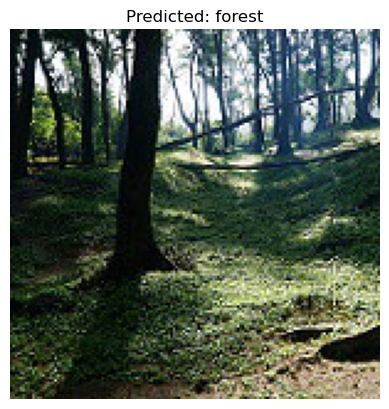

In [121]:
# Example: Show any predicted file
predicted_file = list(pred_results.keys())[50]
show_prediction(os.path.join(folder_path, predicted_file), pred_results[predicted_file])